In [1]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe
from scipy import signal
from scipy import misc
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import torch
from skimage import io

In [2]:
BATCH_SIZE = 16

train_path = "ori+TB/train/"
test_path = "ori+TB/test/"


transform = transforms.Compose(
    [   #transforms.CenterCrop(128),
        transforms.Resize([64,64]),
        transforms.RandomRotation(10),
#        transforms.Resize([128,128]),
        transforms.ToTensor(),
    ])

train_transform = Compose([
    #transforms.CenterCrop(128),
        transforms.Resize([64,64]),
        transforms.RandomRotation(10),
#    transforms.Resize([128,128]),
        transforms.ToTensor(),
    #transforms.Normalize([0, 0, 0], [1, 1, 1])
])

test_transform = Compose([
    #transforms.CenterCrop(128),
        transforms.Resize([64,64]),
        transforms.RandomRotation(10),
#    transforms.Resize([128,128]),
        transforms.ToTensor(),
    #transforms.Normalize([0, 0, 0], [1, 1, 1])
])

trainset = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,drop_last=True,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.ImageFolder(root=test_path,transform=transform)
testloader =  DataLoader(testset, batch_size=BATCH_SIZE,drop_last=True,
                                         shuffle=True, num_workers=4)


torch.Size([16, 3, 64, 64])
torch.Size([16])
tensor(36)


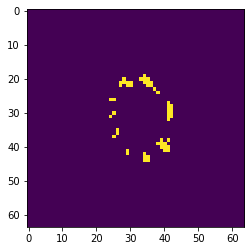

In [3]:
testbatch = iter(trainloader)
testimages, testlabels = testbatch.next()

print(testimages.shape)
print(testlabels.shape)

import matplotlib.pyplot as plt
x = 5
img = testimages[x]
img = torch.where(img > 0.89, img*0+1., img*0.)
plt.imshow(img.numpy()[2])
print(testlabels[x])

In [4]:
device = torch.device("cuda:0")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Apr 28 22:29:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 53%   37C    P3    83W / 370W |   2613MiB / 10240MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
def test():
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
#           _, predicted = torch.max(outputs.data, 1)  
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy : %f %%' % (
      100 * correct / total))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn import init
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple

class _ConvNd(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups', 'bias',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']   

    def __init__(self, in_channels, out_channels, kernel_size, batch_size, stride,
                 padding, dilation, transposed, output_padding,
                 groups, bias, padding_mode):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.batch_size = batch_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        #init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        init.kaiming_normal_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(_ConvNd, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'

class FTconvlayer(_ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size, batch_size = 16, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        batch_size = BATCH_SIZE
        kernel_size = _pair(kernel_size) 
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(FTconvlayer, self).__init__(
            in_channels, out_channels, kernel_size, batch_size, stride, padding, dilation,
            False, _pair(0), groups, bias, padding_mode)

    def quantization_n(self, input, n = 1, max = 1):
      intv = max/(2**n-1)
      qunt = torch.ceil(torch.mul(input,(1/intv)))  #***use ceil instead of floor for small value of n to make sure that not all weights are modified to zero in the beginning, achieves good accuracy for small n
      #the above line divide the whole tensor by the smallest interval (1/2**n-1), which is same as multiply with 2**n-1, then take the floor and finally multiply the whole tensor with the smallest interval
      out = torch.mul(qunt,intv)
      out = torch.clamp(out, min=0, max=max) #make sure the quantized version lies in the interval 0-1, if it's bigger than one just clamp it at one
      return(out)  

    def input_quant(self, input, level = 5):
        max = torch.max(input)
        intv = max/level
        qunt = torch.floor(torch.mul(input,(1/intv)))
        out = torch.mul(qunt, intv)
        out = torch.clamp(out, min=0, max=max)
        return(out)
    
    def weightclamp(self, input):
      return input.clamp_(0)

    def make_complex(self, x):  #converts a real tensor into complex form by adding one extra dimension to it
        #x_i = torch.zeros(x.shape)
        x_i = torch.cuda.FloatTensor(x.shape).fill_(0)
        y = torch.stack((x,x_i),-1)
        return torch.view_as_complex(y)

    def neg_complex_exp(self, x):    #since pytorch does not support complex exponential, implemented using euler formula exp(-jx)=cos(-x)+jsin(-x)
        x_cos = torch.cos(-x)
        x_sin = torch.sin(-x)
        x_euler = torch.stack((x_cos, x_sin), -1)
        return torch.view_as_complex(x_euler)

    def complex_mul(self, x,y):  #this implementation should support broadcasting 
        #result_r = x[...,0] * y[...,0]-x[...,1] * y[...,1]#real
        #result_i = x[...,0] * y[...,1]+x[...,1] * y[...,0]#complex
        #result = torch.stack((result_r,result_i),-1)#stack them together to get the result
        result = x*y
        return result

    def conj_transpose(self, x):  #should support broadcasting
        x = torch.view_as_real(x)
        size = len(x.size())
        x_r = x[...,0]
        x_i = x[...,1]
        x_i_c =-x_i
        x_conj = torch.stack((x_r,x_i_c),-1)
        x_conj_t = torch.transpose(x_conj, size-3, size-2)#size-1 is the dimension for complex representation
        return torch.view_as_complex(x_conj_t)

    def roll_n(self, X, axis, n):
        f_idx = tuple(slice(None, None, None) if i != axis else slice(0, n, None) for i in range(X.dim()))
        b_idx = tuple(slice(None, None, None) if i != axis else slice(n, None, None) for i in range(X.dim()))
        front = X[f_idx]
        back = X[b_idx]
        return torch.cat([back, front], axis)   

    def batch_fftshift2d(self, x):
        real, imag = torch.unbind(x, -1)
        for dim in range(len(real.size())-2, len(real.size())):
            n_shift = real.size(dim)//2
            if real.size(dim) % 2 != 0:
                n_shift += 1  # for odd-sized images
            real = self.roll_n(real, axis=dim, n=n_shift)
            imag = self.roll_n(imag, axis=dim, n=n_shift)
        return torch.stack((real, imag), -1)  # last dim=2 (real&imag)


    def batch_ifftshift2d(self, x):
        real, imag = torch.unbind(x, -1)
        for dim in range(len(real.size()) - 1, len(real.size())-3, -1):
            real = self.roll_n(real, axis=dim, n=real.size(dim)//2)
            imag = self.roll_n(imag, axis=dim, n=imag.size(dim)//2)
        return torch.stack((real, imag), -1)  # last dim=2 (real&imag)

    def propTF(self, u1,L,lambdaa,z):
        batch,M,N = u1.shape
        dx = L/M
        fx = torch.arange(-1/(2*dx),1/(2*dx), 1/L).cuda()
        FX,FY = torch.meshgrid(fx,fx)
        #H = torch.exp(-1j*math.pi*lambdaa*z*(FX**2+FY**2))
        H = self.neg_complex_exp(math.pi*lambdaa*z*(FX**2+FY**2))
        #H = self.batch_fftshift2d(H)
        H = torch.fft.fftshift(H)
        U1 = torch.fft.fft2(torch.fft.fftshift(u1)) #so the U1's dimension is 4, H is 3 so complex_mul needs to support broadcasting
        U2 = self.complex_mul(H,U1)  ####GENERATES ERROR
        u2 = torch.fft.ifftshift(torch.fft.ifft2(U2)) #this step is redundent, can be removed in actual implementation
        return u2


    def seidel_5(self, u0, v0, X, Y, wd, w040, w131, w222, w220, w311):
        beta = math.atan2(u0,v0)
        u0r=math.sqrt(u0**2+v0**2)
        Xr=X*math.cos(beta)+Y*math.sin(beta)
        Yr=-X*math.sin(beta)+Y*math.cos(beta)
        rho2=Xr**2+Yr**2
        w=wd*rho2+w040*rho2**2+w131*u0r*rho2*Xr+ w222*u0r**2*Xr**2+w220*u0r**2*rho2+w311*math.pow(u0r,3)*Xr
        return w

    def circ(self, r):
        out = torch.abs(r)<=1
        return out

    ''' for block mean pytorch does not support reshape using 'F' ordering, so use normal reshape and then permute'''
    def blockmean_batch(self, X, V, W):
        S=X.shape
        B1 = S[0]
        B2 = S[1]
        M = int(S[2] - S[2]%V)
        N = int(S[3] - S[3]%W)
        if(M*N == 0):
            Y = X
            return Y
        MV = int(M/V)  
        NW = int(N/W)
        #XM = np.reshape(X[0:M, 0:N, :],(V, MV, W, NW, -1))
        #XM =  X[0:M, 0:N].reshape(V, MV, W, NW, order="F")
        XM = X[:,:,0:M, 0:N].permute(0,1,3,2).reshape([B1,B2,NW, W, MV, V]).permute(0,1,5,4,3,2)
        #three version of Y in matlab function depends on differen type of inputs, here stick to the double case
        Y = torch.sum(torch.sum(XM,2),3) * (1/(V*W))
        return Y

    def extract_result(self,input,img_size):
        size = input.shape[-1]
        start = int((size-4*img_size)/2)
        end = start + 4*img_size
        output = input[:,:,start:end,start:end]
        return output
    
    def input_pad(self,input,padsize):
      input_size = input.shape[2]
      pad_size_x = int((padsize-input_size)/2)
      pad_size_y = int((padsize-input_size)/2)
      p2d = (pad_size_x, pad_size_y, pad_size_x, pad_size_y)
      input_pad = F.pad(input, p2d, "constant", 0)
      return input_pad 

    def input_adjust(self, input):
      input = torch.mul(input,5)
      input = torch.floor(input)
      output = torch.clamp(input,min=0,max=1)
      return(output)

    def evenkernel(self, input):
      uptri = torch.triu(input,diagonal = 1)
      downtri = torch.flip(torch.triu(input,diagonal = 1),[1,2])
      result = uptri+downtri
      return result

    def extract_result(self,input,img_size):
      size = input.shape[-1]
      start = int((size-img_size)/2)
      end = start + img_size
      output = input[:,:,start:end,start:end]
      return output
    
    def norm(self,input):
      size = input.shape
      output = torch.cuda.FloatTensor(size).fill_(0)
      for i in range(size[0]):
        for j in range(size[1]):
          orig = input[i,j,:,:]
          maxi = torch.max(orig)
          mini = torch.min(orig)
          output[i,j,:,:] = (orig-mini)/(maxi-mini)
      return output

    def kernel_even(self,input):
      input_transpose = torch.transpose(input, 1,2)
      input = input + input_transpose
      return input

    def kernel_hpf_even(self, input, amount):
      # make the center part of the weight to be zero and make the filter symmetrical
      # This function should be placed before quantization
      # amount is the size of the area that are set to 0
      mid = int(input.shape[2]/2)
      input[:,mid-amount:mid+amount,mid-amount:mid+amount] = 0 #set the center part to be zero

      input_transpose = torch.transpose(input, 1,2)
      input = (input + input_transpose)/2
      #even = input
      return input

    def accurate_model_forward(self, input, weight):
        err = 1e-8 #define a very small error term to aviod nan loss due to abs
        #print(input[0, ...])
        #code to quantize the input to certain intervals to simulate dmd
        #with torch.no_grad():
          #input = self.input_quant(input)
        res = input.shape[2]
        xx = res
        yy = xx 
        w = res    
        #output_arr = torch.empty(32,16,w,w) #output dimension of the ftconv layer, hard-coded for easier implementation, 28 for MNIST and 32 for CIFAR
        n_filter_actual = int(self.out_channels/2)
        output_full = torch.cuda.FloatTensor(BATCH_SIZE,self.out_channels,w,w).fill_(0)
        output_sub = torch.cuda.FloatTensor(BATCH_SIZE, int(self.out_channels/2), w, w).fill_(0)
        # Define unit matrix DMD 
        '''unitmatrix = torch.cuda.FloatTensor(17, 17).fill_(0)
        unitmatrix[1:16,1:16]=1
        unitmatrix[7:10,7:10]=0
        idledmd = unitmatrix.repeat(xx,yy)
        '''
        idledmd = torch.cuda.FloatTensor(res, res).fill_(1)
        M,N = idledmd.shape
        L1=1.90e-2*xx/res
        L2=1.09e-2*yy/res
        du=L1/M
        dv=L2/N
        lambdaa = 0.633e-6
        k=2*math.pi/lambdaa
        
        '''Lens Diffraction (Aperture) and Aberration'''
        fu = torch.arange(-1/(2*du),1/(2*du),1/L1)
        #fv = torch.arange(-1/(2*dv),1/(2*dv),1/L2)
        fv = torch.arange(-1/(2*dv),1/(2*dv),1/L2)
        Dxp = 5e-2
        wxp = Dxp/2
        zxp = 200e-3
        lz = lambdaa*zxp
        u0 = 0
        v0 = 0
        f0 = wxp/(lambdaa*zxp)
        '''Lens parameter for aberration (Seidel coefficients), wavefront alteration from spherical waves'''
        wd=0*lambdaa
        w040=4.963*lambdaa
        w131=2.637*lambdaa
        w222=9.025*lambdaa
        w220=7.536*2*lambdaa
        w311=0.157*12*lambdaa
        
        Fu,Fv = torch.meshgrid(fu,fv)
        Fu = torch.transpose(Fu,0,1)
        Fv = torch.transpose(Fv,0,1)
        W = self.seidel_5(u0,v0,-lz*Fu/wxp,-lz*Fv/wxp,wd,w040,w131,w222,w220,w311).cuda() #same as the matlab calculation
        #H = circ(torch.sqrt(Fu**2 + Fv**2)/f0)*torch.exp(-1j*k*W)#same as matlab calculation
        H = self.complex_mul(self.make_complex(self.circ(torch.sqrt(Fu**2 + Fv**2)/f0).float().cuda()),self.neg_complex_exp(k*W))
#-----------------------from here is the actual training, before the loop is basically constants/parameters genreation, which does not needs to be backproped     
        for c_in in range(input.shape[1]): # iters for number of input channels
            signal = input[:,c_in,:,:] #the dimension of signal is 3, with one batch dimension
            weight_raw = weight[:,c_in,:,:] #the dimension of weights are now 3
            #apply high pass filter and make kernel even
            #weight_raw.data = self.kernel_even(weight_raw.data)
            weight_raw.data = self.kernel_hpf_even(weight_raw.data,3)
            weight_raw.data = self.quantization_n(weight_raw.data, 1, 1)
            #print(weight_raw[0,...])
            #weight_raw.data = torch.clamp(weight_raw.data, min=0, max=1)
            '''interleave dimension needs to be changed since now the first dimension is batch dimension'''
            #sw = torch.repeat_interleave(signal,4, dim=1)
            #sw = torch.repeat_interleave(sw,4, dim=2)
            dmd_1 = self.make_complex(self.input_pad(signal,res)) #dimension of dmd1 is now 4, first dimension is now batch dimension, so propTF needs to be changed accordingly
            '''interleave dimension also needs to be changed here'''
            #kk = torch.repeat_interleave(weight_raw,20, dim=1)#due to alignment reason, adjust the minimum unit of kernels to 50*50 pixles, so effective kernek size is 84*84
            #kk = torch.repeat_interleave(kk,20, dim=2)
            #dmd_kk = self.input_pad(kk,res)
            #dmd_kk = self.evenkernel(weight_raw)
            #dmd_kk = weight_raw
            
            #now need to implement propTF function
            u2 = self.propTF(dmd_1,1.9e-2, lambdaa, 1.9e-2)
            #u2 = dmd_1
            
            '''Fourier Transform after first lens'''
            Gg = torch.fft.fftshift(torch.fft.fft2(u2))
            Gi = self.complex_mul(Gg,self.conj_transpose(H))
            Gi = Gi.unsqueeze(1)
            
            '''dot product in the fourier plane'''
            Gii = self.complex_mul(Gi,self.make_complex(weight_raw))
            '''Then get the result in real space'''
            Grs = torch.fft.ifft2(torch.fft.ifftshift(Gii))
            Grs = torch.view_as_real(Grs)
            #Ii = torch.abs(Grs)**2
            Ii = torch.sqrt(Grs[...,0]**2+Grs[...,1]**2+err)
            #Ii = Grs[...,0]**2+Grs[...,1]**2 #take the squre to represent light intensity
            op_abs = Ii#op_abs = self.extract_result(Ii,32)
            output_full += op_abs
        #output_sub = output_full[:, 0:n_filter_actual, :, :] - output_full[:, n_filter_actual:, :, :]
        return output_full

    def forward(self, input):
        return self.accurate_model_forward(input, self.weight)
        
        #shape of input is [32,1,28,28], shape of kernel(weight) is [16,1,5,5]


class FFTconv(nn.Module):
    def __init__(self):
        super(FFTconv, self).__init__()
        self.conv1 = FTconvlayer(3, 16, 64) #outdimension should be [32,16,28,28] (1/3,:,5/28/32) depends on whether training in fourier domain or no
        #self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc01 = nn.Linear(16 * 32 * 32, 256)   #self.fc01 = nn.Linear(16 * 32 * 32, 256)
        self.fc02 = nn.Linear(256, 100) #class number
        self.drop_layer = nn.Dropout(p=0.15)
    
    def forward(self, x):
        #x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = torch.where(x > 0.9, x*0+1., x*0.)
        x = self.bn1(self.pool1(self.conv1(x)))
        x = x.view(16, 16 * 32 * 32)  #NEEDS UPDATE x = x.view(64, 16 * 32 * 32)
        #x = self.drop_layer(x)
        x = F.relu(self.fc01(x))
        #x = self.drop_layer(x)
        x = self.fc02(x)
        return x

net = FFTconv()    


if device:
    net.to(device)
    #torch.backends.cudnn.benchmark = True
    print("put net onto GPU")
print(net)

put net onto GPU
FFTconv(
  (conv1): FTconvlayer(3, 16, kernel_size=(64, 64), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc01): Linear(in_features=16384, out_features=256, bias=True)
  (fc02): Linear(in_features=256, out_features=100, bias=True)
  (drop_layer): Dropout(p=0.15, inplace=False)
)


In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.000390625, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.000390625) #default learning rate for adam is 0.001
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def adjust_learning_rate(optimizer, epoch, init_lr, freq):
    """Sets the learning rate to the initial LR decayed by 2 every n epochs"""
    lr = init_lr * (0.3 ** (epoch // freq))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
for epoch in range(50):  # loop over the dataset multiple times
    print('Training epoch ', epoch)
    start_time = time.time()
    running_loss = 0.0
    adjust_learning_rate(optimizer, epoch, 0.000390625, 10)
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    test()

print('Finished Training')

Training epoch  0


E:\anaconda\envs\GAN\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[1,   200] loss: 2.856
[1,   400] loss: 1.342
[1,   600] loss: 0.854
[1,   800] loss: 0.511
[1,  1000] loss: 0.336
[1,  1200] loss: 0.251
[1,  1400] loss: 0.215
[1,  1600] loss: 0.179
[1,  1800] loss: 0.130
[1,  2000] loss: 0.123
[1,  2200] loss: 0.144
[1,  2400] loss: 0.142
[1,  2600] loss: 0.148
[1,  2800] loss: 0.124
[1,  3000] loss: 0.105
[1,  3200] loss: 0.097
[1,  3400] loss: 0.110
[1,  3600] loss: 0.078
[1,  3800] loss: 0.093
[1,  4000] loss: 0.094
[1,  4200] loss: 0.117
[1,  4400] loss: 0.064
[1,  4600] loss: 0.083
[1,  4800] loss: 0.045
[1,  5000] loss: 0.087
[1,  5200] loss: 0.078
[1,  5400] loss: 0.057
[1,  5600] loss: 0.055
Accuracy : 94.423333 %
Training epoch  1
[2,   200] loss: 0.062
[2,   400] loss: 0.054
[2,   600] loss: 0.049
[2,   800] loss: 0.086
[2,  1000] loss: 0.047
[2,  1200] loss: 0.074
[2,  1400] loss: 0.048
[2,  1600] loss: 0.039
[2,  1800] loss: 0.068
[2,  2000] loss: 0.033
[2,  2200] loss: 0.073
[2,  2400] loss: 0.038
[2,  2600] loss: 0.034
[2,  2800] loss:

[12,  5200] loss: 0.001
[12,  5400] loss: 0.001
[12,  5600] loss: 0.003
Accuracy : 97.863333 %
Training epoch  12
[13,   200] loss: 0.004
[13,   400] loss: 0.001
[13,   600] loss: 0.001
[13,   800] loss: 0.002
[13,  1000] loss: 0.001
[13,  1200] loss: 0.001
[13,  1400] loss: 0.001
[13,  1600] loss: 0.002
[13,  1800] loss: 0.000
[13,  2000] loss: 0.000
[13,  2200] loss: 0.000
[13,  2400] loss: 0.002
[13,  2600] loss: 0.002
[13,  2800] loss: 0.004
[13,  3000] loss: 0.000
[13,  3200] loss: 0.000
[13,  3400] loss: 0.001
[13,  3600] loss: 0.000
[13,  3800] loss: 0.002
[13,  4000] loss: 0.000
[13,  4200] loss: 0.001
[13,  4400] loss: 0.000
[13,  4600] loss: 0.001
[13,  4800] loss: 0.001
[13,  5000] loss: 0.006
[13,  5200] loss: 0.001
[13,  5400] loss: 0.002
[13,  5600] loss: 0.000
Accuracy : 98.323333 %
Training epoch  13
[14,   200] loss: 0.000
[14,   400] loss: 0.002
[14,   600] loss: 0.001
[14,   800] loss: 0.000
[14,  1000] loss: 0.000
[14,  1200] loss: 0.000
[14,  1400] loss: 0.000
[14,

[24,  2200] loss: 0.000
[24,  2400] loss: 0.002
[24,  2600] loss: 0.000
[24,  2800] loss: 0.000
[24,  3000] loss: 0.000
[24,  3200] loss: 0.000
[24,  3400] loss: 0.000
[24,  3600] loss: 0.000
[24,  3800] loss: 0.000
[24,  4000] loss: 0.000
[24,  4200] loss: 0.000
[24,  4400] loss: 0.000
[24,  4600] loss: 0.000
[24,  4800] loss: 0.000
[24,  5000] loss: 0.000
[24,  5200] loss: 0.000
[24,  5400] loss: 0.000
[24,  5600] loss: 0.000
Accuracy : 98.513333 %
Training epoch  24
[25,   200] loss: 0.000
[25,   400] loss: 0.000
[25,   600] loss: 0.000
[25,   800] loss: 0.002
[25,  1000] loss: 0.000
[25,  1200] loss: 0.000
[25,  1400] loss: 0.000
[25,  1600] loss: 0.000
[25,  1800] loss: 0.000
[25,  2000] loss: 0.000
[25,  2200] loss: 0.000
[25,  2400] loss: 0.000
[25,  2600] loss: 0.000
[25,  2800] loss: 0.000
[25,  3000] loss: 0.000
[25,  3200] loss: 0.001
[25,  3400] loss: 0.000
[25,  3600] loss: 0.000
[25,  3800] loss: 0.000
[25,  4000] loss: 0.000
[25,  4200] loss: 0.000
[25,  4400] loss: 0.00

[35,  5200] loss: 0.000
[35,  5400] loss: 0.000
[35,  5600] loss: 0.000
Accuracy : 98.543333 %
Training epoch  35
[36,   200] loss: 0.000
[36,   400] loss: 0.000
[36,   600] loss: 0.000
[36,   800] loss: 0.000
[36,  1000] loss: 0.000
[36,  1200] loss: 0.000
[36,  1400] loss: 0.000
[36,  1600] loss: 0.000
[36,  1800] loss: 0.000
[36,  2000] loss: 0.000
[36,  2200] loss: 0.000
[36,  2400] loss: 0.000
[36,  2600] loss: 0.000
[36,  2800] loss: 0.000
[36,  3000] loss: 0.000
[36,  3200] loss: 0.000
[36,  3400] loss: 0.000
[36,  3600] loss: 0.000
[36,  3800] loss: 0.000
[36,  4000] loss: 0.000
[36,  4200] loss: 0.000
[36,  4400] loss: 0.000
[36,  4600] loss: 0.000
[36,  4800] loss: 0.000
[36,  5000] loss: 0.000
[36,  5200] loss: 0.000
[36,  5400] loss: 0.000
[36,  5600] loss: 0.000
Accuracy : 98.606667 %
Training epoch  36
[37,   200] loss: 0.000
[37,   400] loss: 0.000
[37,   600] loss: 0.000
[37,   800] loss: 0.000
[37,  1000] loss: 0.000
[37,  1200] loss: 0.000
[37,  1400] loss: 0.000
[37,

[47,  2200] loss: 0.000
[47,  2400] loss: 0.000
[47,  2600] loss: 0.000
[47,  2800] loss: 0.000
[47,  3000] loss: 0.000
[47,  3200] loss: 0.000
[47,  3400] loss: 0.000
[47,  3600] loss: 0.000
[47,  3800] loss: 0.000
[47,  4000] loss: 0.000
[47,  4200] loss: 0.000
[47,  4400] loss: 0.000
[47,  4600] loss: 0.000
[47,  4800] loss: 0.000
[47,  5000] loss: 0.000
[47,  5200] loss: 0.001
[47,  5400] loss: 0.000
[47,  5600] loss: 0.000
Accuracy : 98.533333 %
Training epoch  47
[48,   200] loss: 0.000
[48,   400] loss: 0.000
[48,   600] loss: 0.000
[48,   800] loss: 0.000
[48,  1000] loss: 0.000
[48,  1200] loss: 0.000
[48,  1400] loss: 0.000
[48,  1600] loss: 0.000
[48,  1800] loss: 0.000
[48,  2000] loss: 0.000
[48,  2200] loss: 0.000
[48,  2400] loss: 0.000
[48,  2600] loss: 0.000
[48,  2800] loss: 0.000
[48,  3000] loss: 0.000
[48,  3200] loss: 0.000
[48,  3400] loss: 0.000
[48,  3600] loss: 0.000
[48,  3800] loss: 0.000
[48,  4000] loss: 0.000
[48,  4200] loss: 0.000
[48,  4400] loss: 0.00

batch= iter(trainloader)
images, labels = batch.next()

print(images.shape)
print(labels.shape)

In [ ]:
#turbo 20 epoch: 62.3%

In [ ]:
#turbo 40 epoch: 65.0%

In [ ]:
test = torch.randint(10,(3,5,5))
test_tp = torch.transpose(test,1,2)
output = test+test_tp
#print(output)
test_2 = torch.randint(10,(3,6,6))
test_2[:,2:4,2:4] = 0
print(test_2)

In [ ]:
#resize(64,64)
0.7  50%
0.84  53%

#resize(128,128)